# DCC030 - Introdução a Computação Visual 2017/1
## Trabalho Prático 3 - Contagem de caracteres utilizando morfologia matemática

> Yuri Diego Santos Niitsuma  
> 2011039023


In [18]:
%matplotlib inline
import os
import cv2
from matplotlib import pyplot as plt
import numpy as np
import time as t
print "OpenCV Version : %s " % cv2.__version__

OpenCV Version : 3.1.0 


Seguem as operações morfológicas. Mas não utilizarei em quesito de performance. Essas funções estão muito lento em um Core 2 Duo.

In [19]:
def erode(img, dim_size_x=3, dim_size_y=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (dim_size_x, dim_size_y))
    new_img = img.copy()
    dim_img_x, dim_img_y = img.shape[:2]

    max_value = 0
    for x in xrange(dim_img_x):
        for y in xrange(dim_img_y):
            max_value = 0
            for i in xrange(-divmod(dim_size_x,2)[0], divmod(dim_size_x,2)[0], 1):
                for j in xrange(-divmod(dim_size_y,2)[0], divmod(dim_size_y,2)[0], 1):
                    if 0 <= x + i < dim_img_x and 0 <= y + j < dim_img_y:
                        if kernel[divmod(dim_size_x,2)[0] + i][divmod(dim_size_y,2)[0] + j] == 1:
                            # inverse 0 is white, 255 is black
                            if max_value > img[x+i][y+j]:
                                max_value = img[x+i][y+j]
            new_img[x][y] = max_value
    return new_img

def dilate(img, dim_size_x=3, dim_size_y=3):
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (dim_size_x, dim_size_y))
    new_img = img.copy()
    dim_img_x, dim_img_y = img.shape[:2]
    
    min_value = 0
    for x in xrange(dim_img_x):
        for y in xrange(dim_img_y):
            min_value = 255
            for i in xrange(-divmod(dim_size_x,2)[0], divmod(dim_size_x,2)[0], 1):
                for j in xrange(-divmod(dim_size_y,2)[0], divmod(dim_size_y,2)[0], 1):
                    if 0 <= x + i < dim_img_x and 0 <= y + j < dim_img_y:
                        if kernel[divmod(dim_size_x,2)[0] + i][divmod(dim_size_y,2)[0] + j] == 1:
                            # inverse 0 is white, 255 is black
                            if min_value < img[x+i][y+j]:
                                min_value = img[x+i][y+j]
            new_img[x][y] = min_value
    return new_img

def opening(img, dim_size_x=3, dim_size_y=3):
    return erode(dilate(img, dim_size_x=3, dim_size_y=3), dim_size_x=3, dim_size_y=3)

def closing(img, dim_size_x=3, dim_size_y=3):
    return dilate(erode(img, dim_size_x=3, dim_size_y=3), dim_size_x=3, dim_size_y=3)

Como foi avisado na documentação, a imagem pode vir com problemas no brilho/contraste. No caso do exemplo, a imagem vem em tons mais fortes de cinza.

A classe abaixo foi adicionada **equalize_hist** e **count_letters**.

Os arquivos de entradas devem estar contidos na pasta **dados/**. Detalhes no construtor da Classe.

In [22]:
class Image:
    """class Image for using in Jupyter with OpenCV 3.x.x"""
    name = str() # file name. ex: page1.jpg
    path_input = str() # input dir. ex: dados/
    path_output = str() # output data, if use save method
    color = str() # use 'black' or 'white' to detect points
    line_locations = list()
    img = None # image to do things
    img_original = None # original image
    img_output = None # output image with boxes

    def __init__(self, **kwargs):
        self.name = kwargs.get('name', 'input.jpg')
        self.path_input = kwargs.get('path_input', 'dados/')
        if len(self.path_input) > 0 and self.path_input[-1] != '/':
            self.path_input += '/'
        self.path_output = kwargs.get('path_output', 'export/')
        if len(self.path_output) > 0 and self.path_output[-1] != '/':
            self.path_output += '/'
        self.color = kwargs.get('color', 'black')

    def open_image(self): # Read image with opencv
        img_path = self.path_input + self.name
        self.img = cv2.imread(img_path)
        self.img_original = cv2.imread(img_path)
        if self.img is None:
            print('Arquivo nao carregado, verifique se o nome do arquivo esta correto')
            return False
        else:
            return True

    # Equalizacao do histograma, motivado pela imagem cinza de exemplo da documentacao
    def equalize_hist(self):
        kernel1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
        close = cv2.morphologyEx(self.img,cv2.MORPH_CLOSE,kernel1)
        div = np.float32(self.img)/(close)
        self.img = np.uint8(cv2.normalize(div,div,0,255,cv2.NORM_MINMAX))
        self.img_original = self.img.copy()

    def threshold(self, div_value=180): # Convert to gray and make thresold of image
        # div_value: value between black and white
        img = self.img
        img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        dummy, mask = cv2.threshold(img_gray, div_value, 255, cv2.THRESH_BINARY)
        img_bitwiseand = cv2.bitwise_and(img_gray, img_gray, mask=mask)
        if self.color == 'black':
            dummy, new_img = cv2.threshold(img_bitwiseand, div_value, 255, cv2.THRESH_BINARY_INV)
            # new_img = cv2.adaptiveThreshold(img,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY,11,2)
        elif self.color == 'white':
            dummy, new_img = cv2.threshold(img_bitwiseand, div_value, 255, cv2.THRESH_BINARY)
        else:
            print('Set black or white in beginning of file')
            return None
        self.img = new_img
        return self.img

    def blur(self, dim_size_x = 7, dim_size_y = 7, num_iter = 1): # Remove noise and blur image
        
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (dim_size_x, dim_size_y))
        
        self.img = cv2.dilate(self.img, kernel, iterations=num_iter)
        return self.img

    def draw_rectangles(self, w_max=15, h_max=15): # draw rectangles with boxes on detect pixels
        # for cv 3.x.x return 3 elements
        # cv 2.x.x return 2
        image, contours, hierarchy = cv2.findContours(self.img,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_NONE)

        self.img_output = self.img_original.copy()

        self.line_locations = list()
        self.line_locations.append('x\t\ty\t\tw\t\th\n')

        count = 1
        for contour in contours:
            line = [x, y, w, h] = cv2.boundingRect(contour)

            if w < w_max and h < h_max: # false points?
                continue

            line = list(line)
            line.append(self.count_letters(x, y, w, h))
            string = ''
            for value in line:
                string += str(value)
                string += '\t\t' if value < 1000 else '\t'
            string += '\n'

            self.line_locations.append(string)

            # draw rectangle around contour on original image
            cv2.rectangle(self.img_output, (x, y), (x + w, y + h), (255, 0, 0), 2)
            
            count = count + 1
        
        print('Get ' + str(count - 1) + ' box of words')
        return self.img_output

    # Funcao incompleta, nao consegui
    def count_letters(self, x, y, w, h):
        # print(x, y, w, h)
        word = self.img_original[ y : y + h, x : x + w]
        # word = self.opening(word)
        plt.imshow(word)
        plt.show()
        word = self.closing(word)
        word = self.opening(word)
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (3, 3))
        word = cv2.dilate(word, kernel, 1)
        
        # plt.imshow(word)
        # plt.show()

        return 1


    def save(self): # save on file
        text_file = open(self.path_output + self.name + '.txt', 'w')
        if text_file is not None:
            for line in self.line_locations:
                text_file.write(line)
            text_file.close()
        return cv2.imwrite(self.path_output + self.name, self.img_output)

    def print_on_notebook(self, x=20, y=20, img=None):
        # img = cv2.cvtColor(self.img, cv2.COLOR_BGR2RGB)
        # plt.figure(figsize=(x,y))
        plt.imshow(img)
        plt.show()
        
    def show_output(self, x=20, y=20):
        self.print_on_notebook(x=x, y=y, img=self.img_output)
        
    def show_img(self, x=20, y=20):
        self.print_on_notebook(x=x, y=y, img=self.img)

    def opening(self, img, dim_size_x = 3, dim_size_y = 3):
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (dim_size_x, dim_size_y))
        return cv2.erode(cv2.dilate(img, kernel, 1), kernel, 1)

    def closing(self, img, dim_size_x = 3, dim_size_y = 3):
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (dim_size_x, dim_size_y))
        return cv2.dilate(cv2.erode(img, kernel, 1), kernel, 1)

Não consegui completar como contar quantas letras existem em uma palavra.

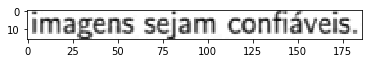

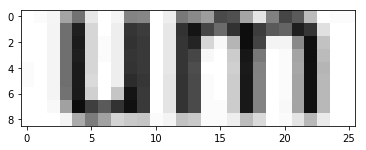

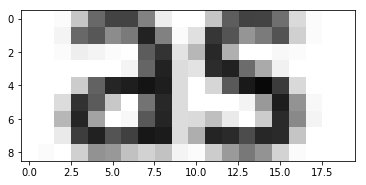

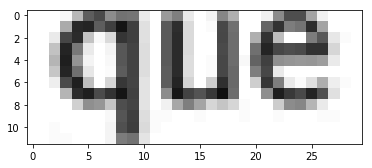

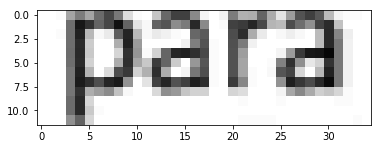

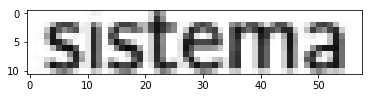

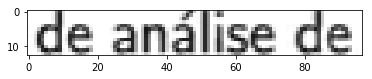

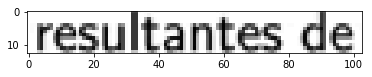

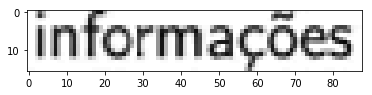

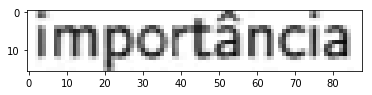

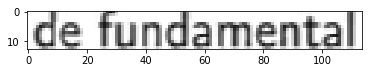

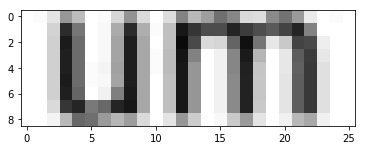

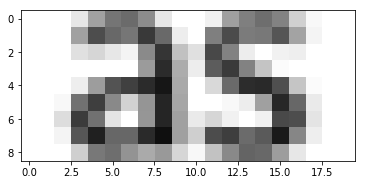

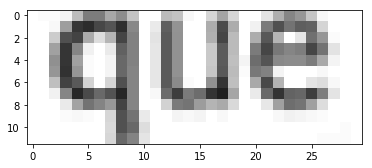

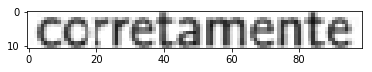

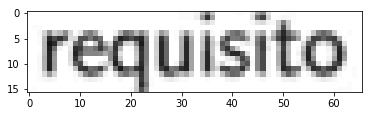

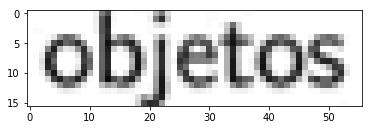

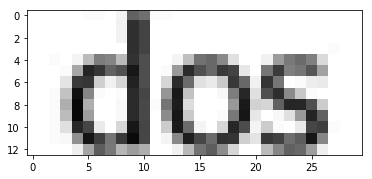

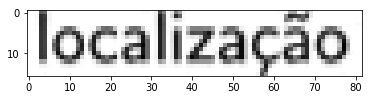

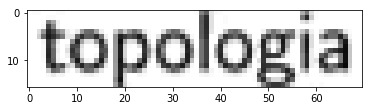

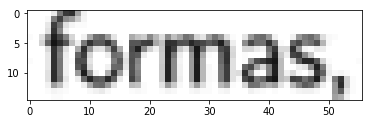

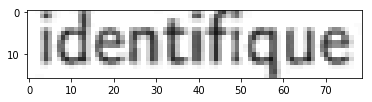

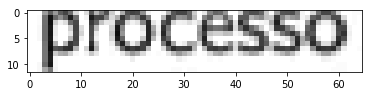

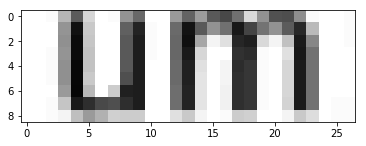

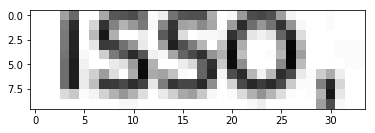

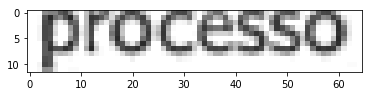

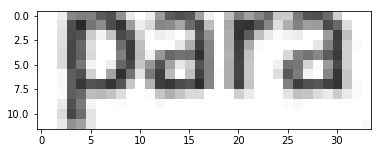

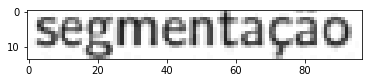

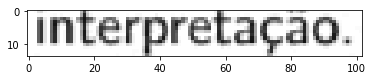

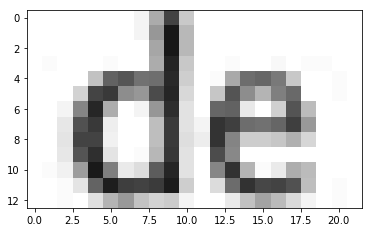

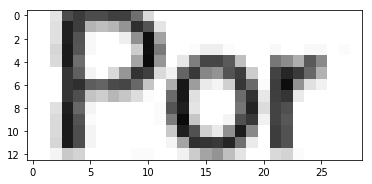

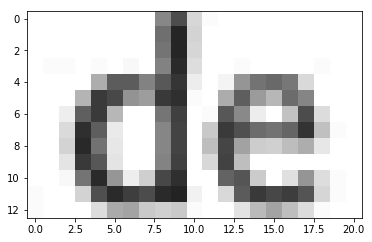

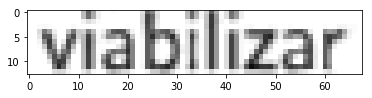

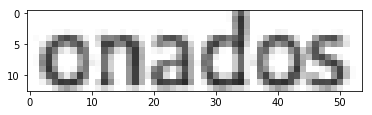

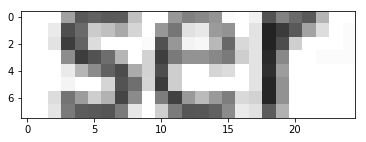

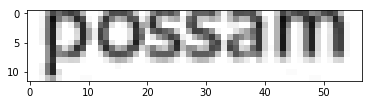

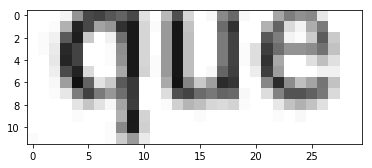

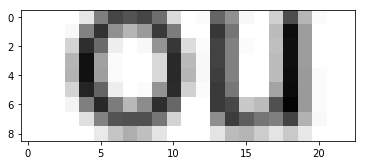

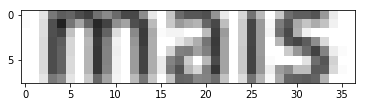

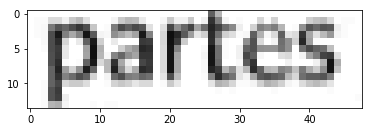

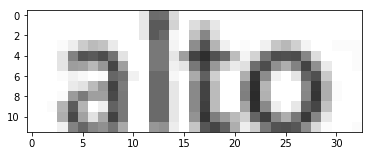

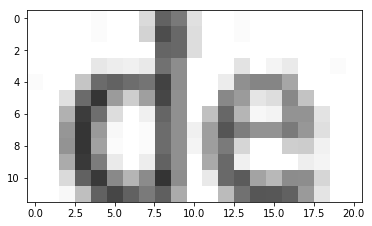

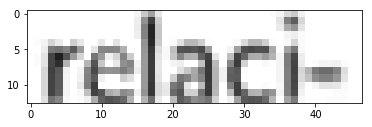

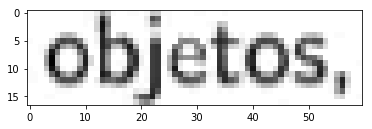

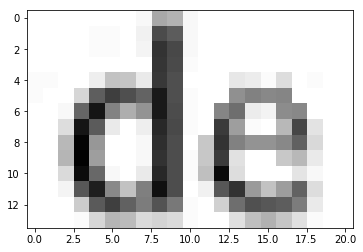

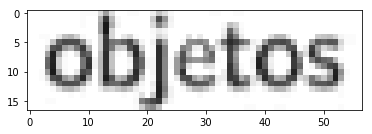

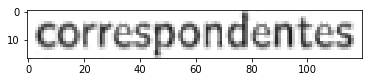

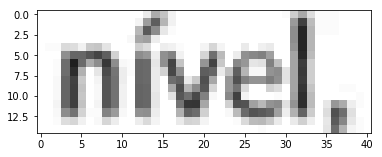

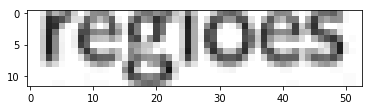

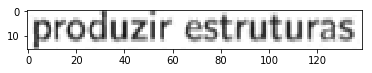

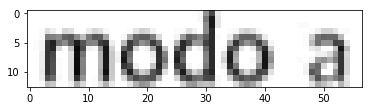

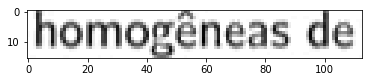

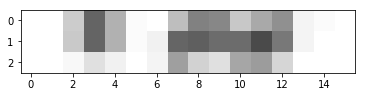

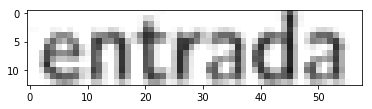

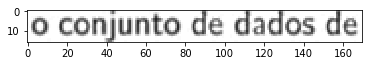

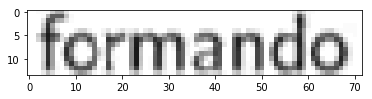

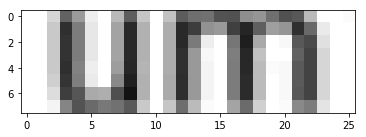

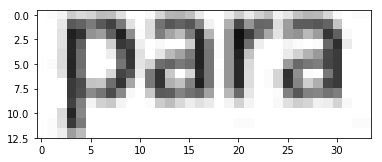

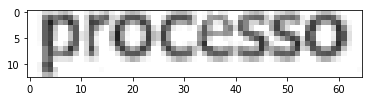

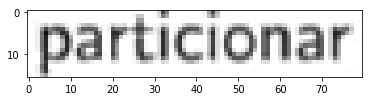

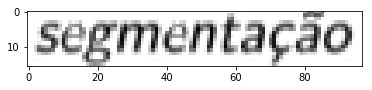

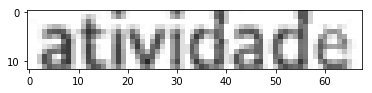

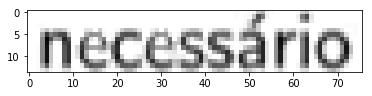

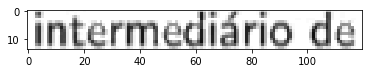

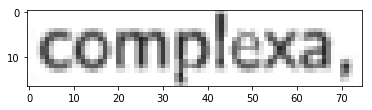

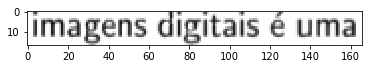

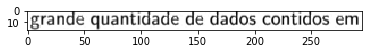

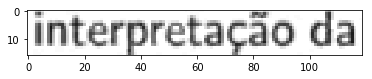

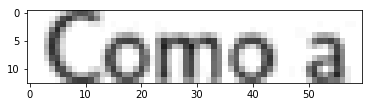

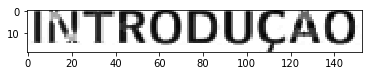

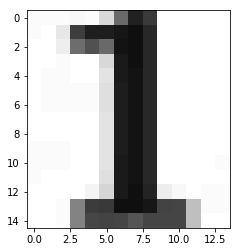

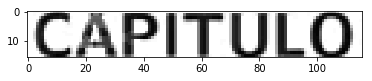

Get 72 box of words


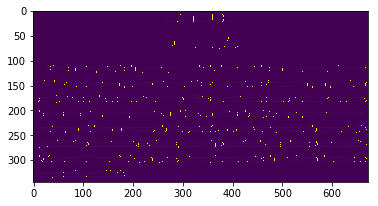

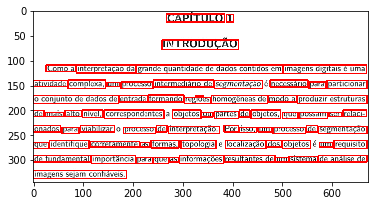

In [23]:
img = Image(name='sample.png')
if not img.open_image():
    raise Exception('failed to open file')
#Equalizar histograma
img.equalize_hist()
img.threshold()
img.blur(7,1)
img.draw_rectangles()
img.show_img()
img.show_output()